In [26]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import xgboost as xgb
import shap
import joblib
from scipy.stats import chi2_contingency, ttest_ind

In [27]:
df=pd.read_csv('final_dataset.csv')

In [28]:
df.drop('BMICategory',axis=1,inplace=True)
df.head(5)

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,UnhealthyDays,HealthScore
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0,33.0,4.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0,0.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0,60.0,3.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0,0.0,1.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0,3.0,2.0


In [29]:
X=df.drop('Diabetes_binary',axis=1)
y=df['Diabetes_binary']

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
print(f"Data split successfully:")
print(f"X_train shape:{X_train.shape}")
print(f"X_test shape:{X_test.shape}")

scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

print("\nFeatures scaled successfully.")

Data split successfully:
X_train shape:(202944, 23)
X_test shape:(50736, 23)

Features scaled successfully.


##### Choosing the Best ML Algorithm

There is no single "best" algorithm for every problem. The standard approach, and what we'll do here, is to train several strong candidate models and compare their performance on our specific dataset. For this binary classification task with tabular data, our candidates are:

1.  **Logistic Regression:** A fantastic, interpretable baseline model. It provides a great starting point.
2.  **Random Forest:** An ensemble of decision trees. It's robust, handles non-linear relationships well (which our EDA suggested), and is less prone to overfitting than a single decision tree.
3.  **LightGBM (LGBM) Classifier:** A high-performance gradient boosting framework. It's known for its speed and accuracy and often wins Kaggle competitions on tabular data.

**Handling Class Imbalance:** We'll use the `class_weight='balanced'` parameter for Logistic Regression and Random Forest, and `is_unbalance=True` for LightGBM. This tells the algorithms to pay more attention to the minority class (diabetes cases), which is exactly what we want.

--- Training Logistic Regression ---

--- Logistic Regression Classification Report ---
              precision    recall  f1-score   support

         0.0       0.95      0.73      0.82     43667
         1.0       0.31      0.76      0.44      7069

    accuracy                           0.73     50736
   macro avg       0.63      0.74      0.63     50736
weighted avg       0.86      0.73      0.77     50736



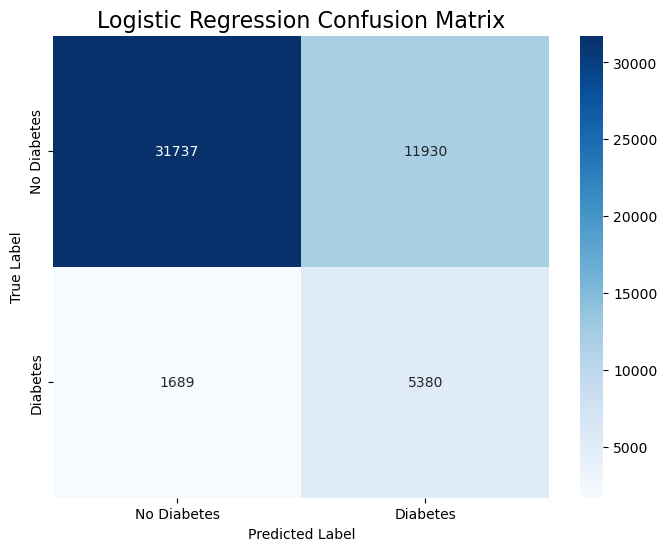

--- Training Random Forest ---

--- Random Forest Classification Report ---
              precision    recall  f1-score   support

         0.0       0.88      0.97      0.92     43667
         1.0       0.46      0.16      0.24      7069

    accuracy                           0.86     50736
   macro avg       0.67      0.57      0.58     50736
weighted avg       0.82      0.86      0.83     50736



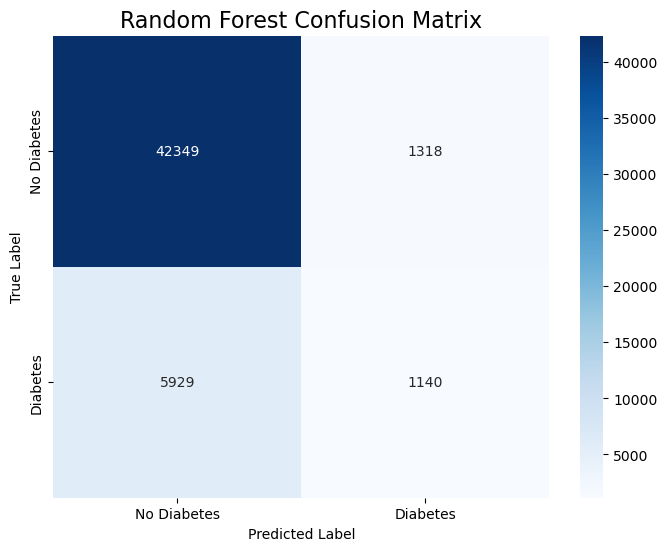

--- Training LightGBM ---
[LightGBM] [Info] Number of positive: 28277, number of negative: 174667
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007727 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 287
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.139334 -> initscore=-1.820833
[LightGBM] [Info] Start training from score -1.820833


c:\Users\mahes\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\mahes\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



--- LightGBM Classification Report ---
              precision    recall  f1-score   support

         0.0       0.96      0.70      0.81     43667
         1.0       0.30      0.80      0.44      7069

    accuracy                           0.72     50736
   macro avg       0.63      0.75      0.63     50736
weighted avg       0.86      0.72      0.76     50736



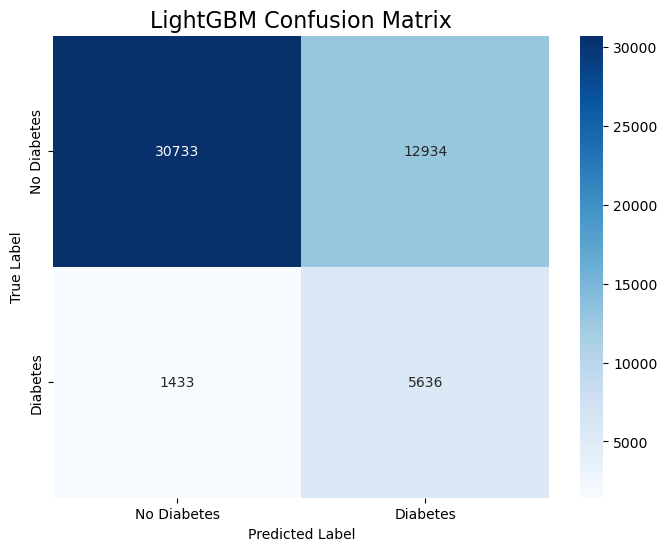

In [32]:
from sklearn.pipeline import Pipeline

models = {
    "Logistic Regression":LogisticRegression(class_weight='balanced',random_state=42,max_iter=1000),
    "Random Forest":RandomForestClassifier(class_weight='balanced',random_state=42),
    "LightGBM":LGBMClassifier(is_unbalance=True, random_state=42)
}

results = {}

for name, model in models.items():
    print(f"--- Training {name} ---")

    # Use scaler as the preprocessor
    pipeline = Pipeline(steps=[
        ('preprocessor', scaler),
        ('classifier', model)
    ])

    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:,1] 

    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test,y_pred_proba)

    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    }

    print(f"\n--- {name} Classification Report ---")
    print(classification_report(y_test,y_pred))

    plt.figure(figsize=(8,6))
    cm = confusion_matrix(y_test,y_pred)
    sns.heatmap(cm, annot=True,fmt='d',cmap='Blues', 
                xticklabels=['No Diabetes','Diabetes'], 
                yticklabels=['No Diabetes','Diabetes'])
    plt.title(f'{name} Confusion Matrix',fontsize=16)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

In [34]:
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values(by=['ROC-AUC', 'Recall'], ascending=False)

print("--- Model Performance Comparison ---")
display(results_df)

--- Model Performance Comparison ---


,Accuracy,Precision,Recall,F1-Score,ROC-AUC
LightGBM,0.716828,0.303500,0.797284,0.439643,0.826670
Logistic Regression,0.731571,0.310803,0.761069,0.441363,0.819629
Random Forest,0.857163,0.463792,0.161268,0.239320,0.789174


### Hyperparameter Tuning with RandomizedSearchCV

Now that we've selected LightGBM as our best model, we'll fine-tune its hyperparameters. This process systematically searches for the optimal model settings to potentially boost performance even further. We use `RandomizedSearchCV` because it's more efficient than searching every single combination (`GridSearchCV`).

In [35]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# Define the hyperparameter space to search
param_dist = {
    'n_estimators': randint(100, 500),
    'learning_rate': uniform(0.01, 0.1),
    'num_leaves': randint(20, 50),
    'max_depth': [-1, 10, 20, 30],
    'reg_alpha': uniform(0,1), # L1 regularization
    'reg_lambda': uniform(0,1) # L2 regularization
}

# Initialize the best model (LightGBM)
lgbm = LGBMClassifier(is_unbalance=True, random_state=42)

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    lgbm, 
    param_distributions=param_dist, 
    n_iter=25, 
    cv=3, 
    scoring='roc_auc', 
    random_state=42, 
    n_jobs=-1, # Using all available CPU cores
    verbose=1
)

# Fit the search to our scaled training data
random_search.fit(X_train_scaled, y_train)

print("\n--- Hyperparameter Tuning Results ---")
print(f"Best Parameters Found: {random_search.best_params_}")
print(f"Best ROC-AUC Score from Search: {random_search.best_score_:.4f}")

best_tuned_model = random_search.best_estimator_

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[LightGBM] [Info] Number of positive: 28277, number of negative: 174667
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005845 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 287
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.139334 -> initscore=-1.820833
[LightGBM] [Info] Start training from score -1.820833

--- Hyperparameter Tuning Results ---
Best Parameters Found: {'learning_rate': 0.052515587449124476, 'max_depth': 10, 'n_estimators': 205, 'num_leaves': 23, 'reg_alpha': 0.18485445552552704, 'reg_lambda': 0.9695846277645586}
Best ROC-AUC Score from Search: 0.8307


#### Feature Importance Analysis

Now that we have a highly optimized model, let's understand *what* it learned. Feature importance tells us which health indicators the model relied on most heavily to make its predictions. This is a critical step for translating our model's performance into real-world, actionable insights.

--- Top 10 Least Important Features ---


,feature,importance
4,Smoker,106
0,HighBP,90
8,Fruits,70
9,Veggies,65
6,HeartDiseaseorAttack,64
7,PhysActivity,51
16,DiffWalk,47
12,NoDocbcCost,36
11,AnyHealthcare,33
5,Stroke,30


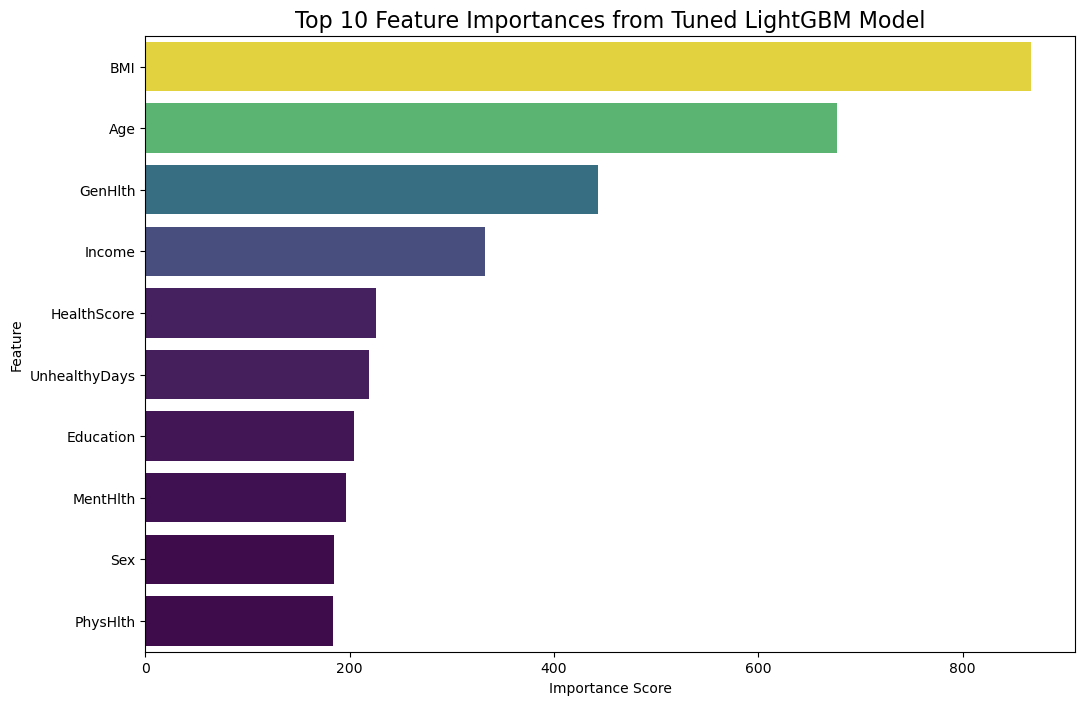

In [38]:
# Extract feature importances from the best tuned model
feature_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_tuned_model.feature_importances_
}).sort_values('importance', ascending=False)

# Display the top 10 features
print("--- Top 10 Least Important Features ---")
display(feature_importances.tail(10))

# Visualize the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='importance',y='feature',data=feature_importances.head(10), 
            palette='viridis',hue='importance',legend=False)
plt.title('Top 10 Feature Importances from Tuned LightGBM Model',fontsize=16)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

### Saving our ML Model

In [40]:
# Save the final, tuned model
joblib.dump(best_tuned_model, 'final_diabetes_model.pkl')

# We re-use the same scaler from before
joblib.dump(scaler, 'scaler.pkl')

print("Final tuned model ('final_diabetes_model.pkl') and scaler have been saved!")

Final tuned model ('final_diabetes_model.pkl') and scaler have been saved!
